## Question 1. ZLG algorithm implementation (50 points)
You are to implement the ZLG algorithem for this problem. We will use a subset of multiclass data where the label is a protein subcellular localization. The 8 features are extracted from the protein sequence. For this problem we are only using points with labels 'MIT' or 'NUC'.

First, read the paper and answer the following questions.
#### 1. What is the idea behind the ZLG algorithm (5 points)?
Data are represented as nodes in a graph, with edge weights represets the similarity between data points. Active learning is performed based on gaussian random field graph by greedily selecting queries from the unlabeled data to minimize the estimated expected risk. Since the graph is modeled as gausian random field, the risk can be efficiently computed using matrix operations.
#### 2. What are the assumptions behind the ZLG algorithm (5 points)?
- Assumes gaussian distribution over the unlabeled nodes
- Labels are binary
- If two unlabeled data point are similar, they should have the same label
- Labeled data points have {0,1} labels while unlabeled data points can have continuous labels in [0,1]

#### 3. What are the pros and cons of the ZLG algorithm (5points)?
- Pros: Algorithm is easy to implement. Due the property of gaussian random field, some calculations have closed form optimal solutions.

- Cons: It takes long to run, $O(n^3)$ per iteration. It suffers from sampling bias.

In [1]:
import numpy as np
import pandas as pd 
from scipy.spatial import distance_matrix
from sklearn.preprocessing import LabelEncoder

A total of 892 data points have labels 'MIT' (244) or 'NUC' (429). We start with the labels of only the first 200 data points (set $Y_k$). The other 792 points are in $Y_u$.

In [2]:
data = pd.read_csv('data/data.csv')
data_CYTNUC = data.loc[data['Label'].isin(['MIT','NUC'])].values
X = data_CYTNUC[:,:8]
y = LabelEncoder().fit_transform(data_CYTNUC[:,-1])

n_l = 200

Xk = X[:n_l,:]
Yk = y[:n_l]
Xu = X[n_l:,:]
Yu = y[n_l:]

(5 points) Let's first construct the weight matrix W. Use t = 0, $\sigma$ as the standard deviation of X. Then calculate the D matrix and the Laplacian matrix (Delta).

In [3]:
def Laplacian_matrix(X):
    # change X to float type
    X = X.astype(float)
    # initialize weight matrix of shape (n_data * n_data)
    weight_matrix = np.zeros(shape = (X.shape[0], X.shape[0]))
    # set sigma = standard deviation of X
    sigma = np.std(X)
    for i in range(weight_matrix.shape[0]):
        # calculate RBF weight matrix
        weight_matrix[i,:] = np.exp(-np.sum((X - X[i,:]) ** 2, axis = 1) / (sigma ** 2))
    Delta = np.diag(weight_matrix.sum(axis = 1)) - weight_matrix
    return Delta

Delta = Laplacian_matrix(X)

(5 points) Now complete the subroutine to compute the minimum-energy solution for the unlabeled instances. (Hint: Use the formula in page 38, Lecture 7.) The function also outputs one submatrix that we will use to select points to query.

In [4]:
def minimum_energy_solution(Delta,n_l,fl):
    """
    Args:
        Delta: The Laplacian matrix. 
        n_l: Number of labeled points. Notice that Delta should have the upper left submatrix 
            corresponding to these n_l points. So when new points get labeled, you may need 
            to rearrange the matrix.
        fl: Known labels.
    Returns:
        Delta_uu_inv: Inverse matrix of the submatrix corresponding to unlabeled points.
        fu: Minimum energy solution of all unlabeled points.
    """
    ## TODO ##
    Delta_uu = Delta[n_l:, n_l:]
    Delta_ul = Delta[n_l:, :n_l]
    Delta_uu_inv = np.linalg.inv(Delta_uu)
    fu = -Delta_uu_inv.dot(Delta_ul).dot(fl)
    return Delta_uu_inv, fu

Delta_uu_inv, fu = minimum_energy_solution(Delta,n_l,Yk)

(15 points) We would like to query the points that minimize the expected risk. To do so, we want to be able to calculate the expected estimated risk after querying any point k. The variable Rhat_fplus_xk refers to $\hat{R}(f^{+x_k})$. fu_xk0 is $f_u^{+(x_k,0)}$ and vice versa for fu_xk1.

In [5]:
def expected_estimated_risk(Delta_uu_inv,k,fu):
    """
    Args:
        Delta_uu_inv: Inverse matrix of the submatrix corresponding to unlabeled points.
        k: index of one unlabeled point with respect to the uu submatrix (not the entire Delta)
        fu: Minimum energy solution of all unlabeled points.
    Returns:
        Rhat_fplus_xk: Expected estimated risk after querying node k
    """
    ## fu plus xk, yk = 0
    fu_xk0 = fu + (0 - fu[k])*Delta_uu_inv[:,k]/Delta_uu_inv[k,k]
    ## fu plus xk, yk = 1
    fu_xk1 = fu + (1 - fu[k])*Delta_uu_inv[:,k]/Delta_uu_inv[k,k]
    
    ## TODO ##
    Rhat_fplus_xk0 = np.minimum(fu_xk0, 1-fu_xk0).sum()
    Rhat_fplus_xk1 = np.minimum(fu_xk1, 1-fu_xk1).sum()
    Rhat_fplus_xk = (1 - fu[k])*Rhat_fplus_xk0 + fu[k]*Rhat_fplus_xk1
    return Rhat_fplus_xk
        

(5 points) Compute the above expected estimated risk for all unlabeled points and select one to query.

In [6]:
def zlg_query(Delta_uu_inv,n_l,fu,n_samples):
    """
    Args:
        Delta_uu_inv: Inverse matrix of the submatrix corresponding to unlabeled points.
        n_l: Number of labeled points.
        fu: Minimum energy solution of all unlabeled points.
        n_samples: Number of samples.
    Returns:
        query_idx: the idx of the point to query, wrt the unlabeled points 
                (idx is 0 if it's the first unlabeled point)
    """
    n_u = n_samples - n_l
    query_idx = 0
    min_Rhat = np.inf
    ## TODO ##
    for i in range(n_u):
        tmp_Rhat = expected_estimated_risk(Delta_uu_inv, i, fu)
        if tmp_Rhat < min_Rhat:
            min_Rhat = tmp_Rhat
            query_idx = i
    return query_idx

Let's try query 100 points. Which points are queried? Compare with random queries and make a plot.

In [7]:
def accuracy(fu, Yu):
    acc = 0.0
    for i in range(len(fu)):
        if fu[i] > 0.5 and Yu[i] == 1:
            acc += 1
        if fu[i] < 0.5 and Yu[i] == 0:
            acc += 1
    return acc / len(Yu)

In [8]:
# ZLG query
n_iter = 100
n_samples = X.shape[0]
accuracy_history_ZLG = []
for t in range(n_iter):
    ## edit this block ##
    query_idx = zlg_query(Delta_uu_inv,n_l,fu,n_samples)
    Yk = np.append(Yk,Yu[query_idx])
    Yu = np.delete(Yu,query_idx)
    Xk = np.append(Xk,[Xu[query_idx,:]],axis=0)
    Xu = np.delete(Xu,query_idx, 0)
    n_l += 1
    Delta = Laplacian_matrix(np.concatenate((Xk,Xu),axis=0))
    Delta_uu_inv, fu = minimum_energy_solution(Delta,n_l,Yk)
#     print(query_idx)
    ## TODO ##
    accuracy_history_ZLG.append(accuracy(fu, Yu))

In [9]:
# random query
n_l = 200
accuracy_history_random = []
Xk = X[:n_l,:]
Yk = y[:n_l]
Xu = X[n_l:,:]
Yu = y[n_l:]
for t in range(n_iter):
    ## edit this block ##
    query_idx = np.random.randint(0, Yu.shape[0])
    Yk = np.append(Yk,Yu[query_idx])
    Yu = np.delete(Yu,query_idx)
    Xk = np.append(Xk,[Xu[query_idx,:]],axis=0)
    Xu = np.delete(Xu,query_idx, 0)
    n_l += 1
    Delta = Laplacian_matrix(np.concatenate((Xk,Xu),axis=0))
    Delta_uu_inv, fu = minimum_energy_solution(Delta,n_l,Yk)
#     print(query_idx)
    ## TODO ##
    accuracy_history_random.append(accuracy(fu, Yu))

In [10]:
import matplotlib.pyplot as plt

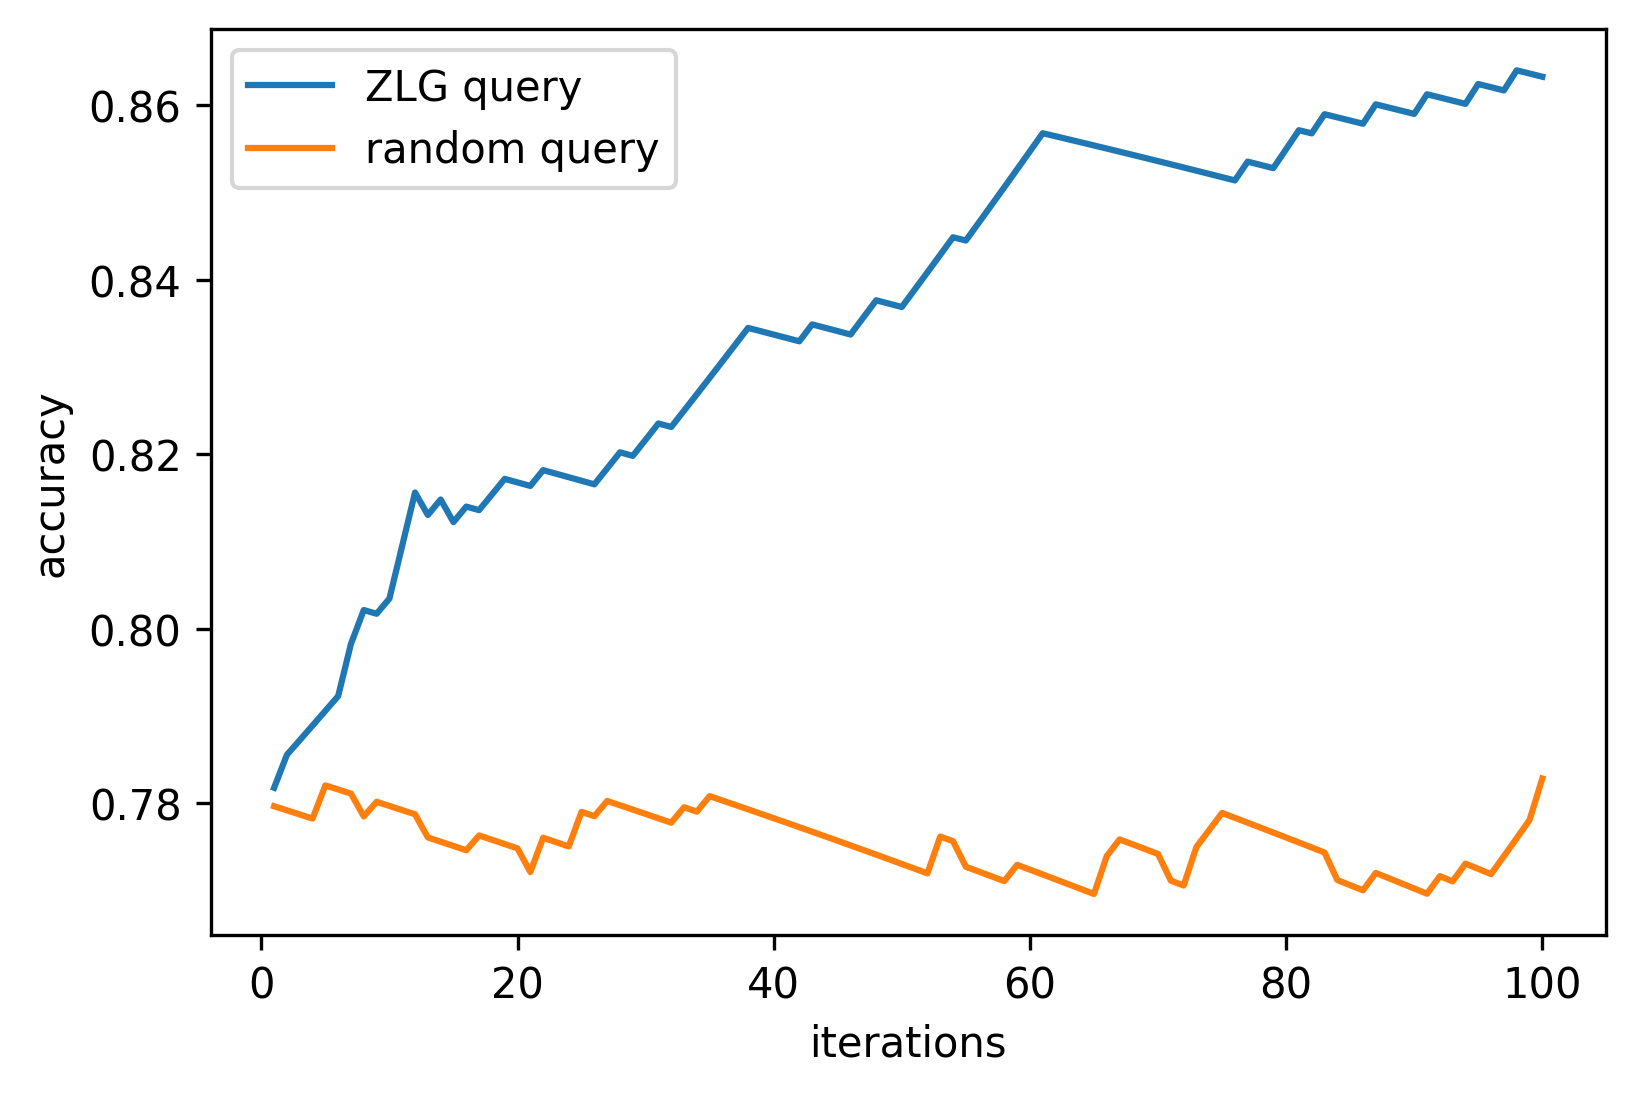

In [11]:
time = np.linspace(1,n_iter,n_iter)
fig, ax = plt.subplots(dpi = 300)
ax.plot(time, accuracy_history_ZLG, label = 'ZLG query')
ax.plot(time, accuracy_history_random, label = 'random query')
ax.set_xlabel('iterations')
ax.set_ylabel('accuracy')
ax.legend()

### Explaination
In 100 iterations, ZLG algorithm significantly achieves a higher accuray than random sampling. It shows the benefits of active learning.

Bonus question (Your grade will not exceed 100 for this homework): For this dataset, how many labeled data points do you actually need, to train the model sufficiently well? And why?